In [ ]:
!pip install Sastrawi
!pip install transformers
!pip install torch

Pada projek kali ini akan menggunakan dataset review pengguna terhadap aplikasi tokopedia yang diambil dari google play store. Seluruh data terdiri atas teks review asli yang dituliskan oleh pengguna. Tulisan review ini mencerminkan berbagai pengalaman pengguna, mulai dari kepuasan terhadap fitur aplikasi hingga keluhan terhadap kinerja atau layanan.

Data ini sangat beragam dalam panjang kalimat, gaya bahasa, dan tingkat emosi. Sehingga cocok digunakan untuk membangun model analisis sentimen yang mampu mengidentifikasi opini positif, netral, dan negatif.

In [ ]:
import pandas as pd
import re
import string
import time
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

In [ ]:
df = pd.read_csv('tokopedia_reviews.csv')
df

,userName,score,content
0,Pengguna Google,5,wOw
1,Pengguna Google,5,👍👍👍
2,Pengguna Google,5,bagus banget
3,Pengguna Google,1,"saya pengguna lama tokped, sebelum ada toko or..."
4,Pengguna Google,5,smog sm mnguntungkn
...,...,...,...
9995,Fahmi Hakim,1,ganggu iklan nya bodoh
9996,dirgantara tio,4,tokopedia untuk jual beli online aman seler am...
9997,Ratih Kurnia,3,harganya kalau ada voucher/diskon emang murah ...
9998,Sakti Nagaria,1,"gak asyik, produk mahal. vocernya tipu²"


## Preprocessing Data & Ekstraksi Fitur

Membersihkan teks dari URL, angka atau tanda baca

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[0-9]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

df['cleaned'] = df['content'].astype(str).apply(clean_text)

stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

def preprocess(text):
    words = text.split()
    words = [word for word in words if word not in stopwords]
    return stemmer.stem(' '.join(words))

df['processed'] = df['cleaned'].apply(preprocess)

Mengubah teks menjadi representasi numerik berdasarkan frekuensi kata menggunakan tf-idf. Alasan menggunakan tf-idf untuk analisis sentimen kali ini adalah tf-idf efektif dalam menangkap kata penting dan biasa digunakan sebagai ekstraksi fitur untuk model deep learning ringan.



In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['processed'].astype(str)).toarray()

In [ ]:
df

,userName,score,content,cleaned,processed
0,Pengguna Google,5,wOw,wow,wow
1,Pengguna Google,5,👍👍👍,👍👍👍,
2,Pengguna Google,5,bagus banget,bagus banget,bagus banget
3,Pengguna Google,1,"saya pengguna lama tokped, sebelum ada toko or...",saya pengguna lama tokped sebelum ada toko ore...,guna lama tokped toko oren udah pake tokped ke...
4,Pengguna Google,5,smog sm mnguntungkn,smog sm mnguntungkn,smog sm mnguntungkn
...,...,...,...,...,...
9995,Fahmi Hakim,1,ganggu iklan nya bodoh,ganggu iklan nya bodoh,ganggu iklan nya bodoh
9996,dirgantara tio,4,tokopedia untuk jual beli online aman seler am...,tokopedia untuk jual beli online aman seler am...,tokopedia jual beli online aman seler amanah t...
9997,Ratih Kurnia,3,harganya kalau ada voucher/diskon emang murah ...,harganya kalau ada voucherdiskon emang murah t...,harga kalau voucherdiskon emang murah kan tand...
9998,Sakti Nagaria,1,"gak asyik, produk mahal. vocernya tipu²",gak asyik produk mahal vocernya tipu²,gak asyik produk mahal vocernya tipu


## Pelabelan Data (Sentimen)

Menggunakan model IndoBERT terlatih khusus untuk klasifikasi sentimen dengan dataset bahasa indonesia. Dengan menggunakan model BERT diharapkan bisa menghasilkan label secara otomatis dengan hasil yang akurat untuk tahap awal klasifikasi

In [ ]:
model_id = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained("mdhugol/indonesia-bert-sentiment-classification")

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


## Encode Label

In [ ]:
def classify_sentiment_batch(texts):
    results = sentiment_pipeline(texts, truncation=True, padding=True)
    return [r['label'].lower() for r in results]

batch_size = 32
labels = []

for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned'].iloc[i:i+batch_size].tolist()
    batch_labels = classify_sentiment_batch(batch_texts)
    labels.extend(batch_labels)

df['label'] = labels

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
df['label'].value_counts()
df[['content', 'label']].sample(10)

,content,label
9306,bagusss,label_0
8683,Tokopedia buatan anak bangsa inovatif sangat m...,label_0
1288,ok,label_0
7668,good,label_0
5477,Susah banget dapet gratis ongkirnya tolong di ...,label_2
5018,Ok,label_0
4362,Kurir rekomendasi tolol banget yang bikin fitu...,label_2
9775,"Sekelas Tokopedia pelayanan CS nya payah, duit...",label_2
6850,"Hati hati banyak sekali pedagang yg curang, ka...",label_2
4095,"toko online yg terpercaya,",label_0


In [ ]:
le = LabelEncoder()
y_enc = le.fit_transform(df['label'])
y_cat = to_categorical(y_enc)

## Split Data dan Latih Model ML

Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_cat, test_size=0.2, random_state=42)

Membangun arsitektur deep learning

In [ ]:
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_cat.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.9915 - loss: 0.0298 - val_accuracy: 0.8495 - val_loss: 0.8153
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9933 - loss: 0.0287 - val_accuracy: 0.8555 - val_loss: 0.8269
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9912 - loss: 0.0332 - val_accuracy: 0.8540 - val_loss: 0.8433
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9919 - loss: 0.0316 - val_accuracy: 0.8500 - val_loss: 0.8642
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9927 - loss: 0.0304 - val_accuracy: 0.8500 - val_loss: 0.8835
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9918 - loss: 0.0295 - val_accuracy: 0.8515 - val_loss: 0.8491
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9930 - loss: 0.0286 - val_accuracy: 0.8510 - val_loss: 0.8951
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9928 - loss: 0.0289 - 

## Evaluasi

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8530 - loss: 0.9021


Berdasarkan hasil pelatihan model selama 15 epoch, terlihat bahwa akurasi pada data training sangat tinggi, konsisten berada di atas 99%, yang menunjukkan bahwa model mampu belajar dengan sangat baik dari data latih. Namun, akurasi pada data validasi stagnan di sekitar 84–85% tanpa peningkatan signifikan seiring bertambahnya epoch.

Nilai loss pada data validasi cenderung meningkat, menandakan bahwa model mengalami overfitting — yaitu model terlalu menyesuaikan diri dengan data pelatihan sehingga kehilangan kemampuan generalisasi terhadap data baru. Hal ini dapat dilihat dari gap yang cukup besar antara training loss yang rendah dan validation loss yang justru naik.

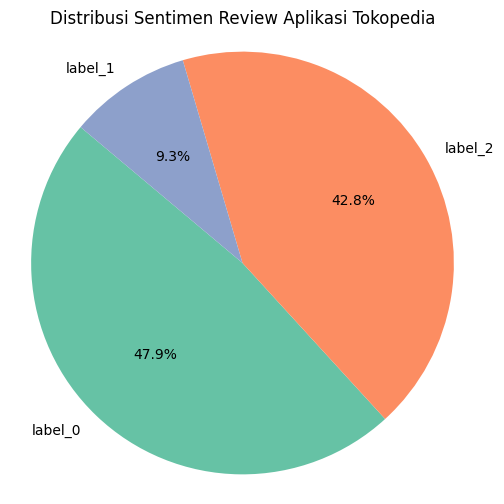

<ipython-input-21-9f520adfed70>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Set2")


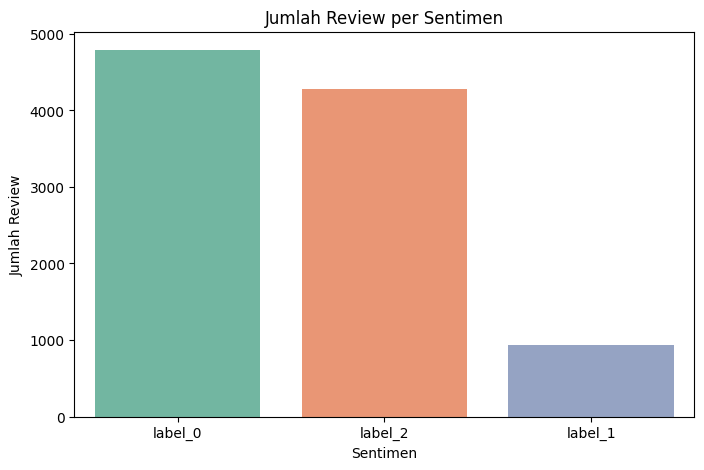

In [ ]:
sentiment_counts = df['label'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title('Distribusi Sentimen Review Aplikasi Tokopedia')
plt.axis('equal')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Set2")
plt.title('Jumlah Review per Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.show()


In [ ]:
sentiment_counts = df['label'].value_counts().reset_index()
sentiment_counts.columns = ['Label', 'Jumlah']
print(sentiment_counts)

     Label  Jumlah
0  label_0    4790
1  label_2    4277
2  label_1     933


Label 0 = Positif

Label 1 = Netral

Label 2 = Negatif

Setelah melakukan evaluasi dan visualisasi, model yang dibangun berhasil mengelompokkan data ke dalam tiga kategori sentimen: positif (label_0), negatif (label_2), dan netral (label_1). Dari seluruh data yang diproses, mayoritas review adalah review positif, dengan jumlah sebanyak 4790 review, diikuti oleh review negatif sebanyak 4277 review, dan sisanya 933 review tergolong netral. Hal ini menunjukkan bahwa secara umum, pengguna memiliki persepsi yang baik terhadap aplikasi tokopedia, meskipun hanya berbeda tipis dengan sentimen negatif. Distribusi label yang cukup seimbang antara positif dan negatif ini juga menunjukkan bahwa model perlu menangani kedua jenis sentimen dengan baik agar tidak bias terhadap salah satu kelas.